In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from impedance.models.circuits import CustomCircuit, Randles
from impedance import preprocessing
from galvani import BioLogic
import glob
import re
import os
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import cmath

In [2]:
#pip install impedance
#pip install glob2
#pip install matplotlib
#pip install pandas
#pip install galvani
#pip install impedance
#pip install eclabfiles 
#pip --version
#pip install openpyxl
#pip install interruptingcow  #timeout module based on using singal alarm --> works only for unix based

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Step-by-step EC analysis

## User Inputs

In [4]:
#file directory
input_dir='EClab/2024/240310/'
output_dir='EClab/2024/240310/'
exp_id="240310_1_"
techniques_dict = {'_02_': 'OCV', '_03_':'CV', '_04_': 'CVA', '_05_': 'PEIS','_06_':'CP', '_07_':'LSV'}

#parameters
sample_no=10
geo_area = 0.196 #cm2
ref_electrode = 'Ag/AgCl (Sat. KCl)'
ref_pot=0.200 #V
pH=0

#CV
cv_reps=2

#LSV
LSV_reps=3

#CVA
v_sweep=[20,40,60,80,100] #mV/sec
cva_reps=3
Cs = 0.06 #mF/cm2


## Reading MPR file

In [5]:
def gen_filelist(exp_id, techniques_dict, input_dir=input_dir, ext='.mpr'):
    
    files = glob.glob(input_dir+exp_id+'*'+ext)
    file_list = {}

    for i in files:
        splits = re.split('-|_',i)
        date = splits[0][-6:]
        round_no = float(splits[1])
        if date not in file_list.keys():
            file_list[date] = {}
        if round_no not in file_list[date].keys():
                file_list[date][round_no] = {}

        for k,v in techniques_dict.items():
            if k+v in i:
                file_list[date][round_no][v] = i
    return file_list

In [6]:
def read_mpr(file_list, exp_id, technique):
    filename= get_mpr_name(file_list, exp_id, technique)
    mpr_file = BioLogic.MPRfile(filename)
    df = pd.DataFrame(mpr_file.data)
    return df

In [7]:
def get_mpr_name(file_list, exp_id, technique, ext='.mpr'):
    exp_date = re.split('-|_',exp_id)[0]
    roundno = re.split('-|_',exp_id)[1]
    filename = file_list[exp_date][int(roundno)][technique]
    return filename[:-4]+ext

In [8]:
file_list = gen_filelist(exp_id, techniques_dict, input_dir=input_dir)
file_list

{'240310': {1.0: {'OCV': 'EClab/2024/240310\\240310_1_02_OCV_C01.mpr',
   'CV': 'EClab/2024/240310\\240310_1_03_CV_C01.mpr',
   'CVA': 'EClab/2024/240310\\240310_1_04_CVA_C01.mpr',
   'PEIS': 'EClab/2024/240310\\240310_1_05_PEIS_C01.mpr',
   'CP': 'EClab/2024/240310\\240310_1_06_CP_C01.mpr',
   'LSV': 'EClab/2024/240310\\240310_1_07_LSV_C01.mpr'}}}

## Plotting Experiments

In [9]:
def plot_exp(x, axis, plt_type='line', cmap='viridis', xrange=[], fit_array=None, reps=False):
    
    if xrange:
        fltr= np.where( (x[:,0]>=xrange[0]) & (x[:,0]<=xrange[1]) )
        x = x[fltr]
        
    if reps:
        group_list=np.unique(x[:,2]).astype(int)
        for group in group_list:
            loc=np.where(x[:,2]==group)
            if plt_type=='line':
                axis.plot(x[:,0][loc], x[:,1][loc], label=group)
            else:
                axis.scatter(x[:,0][loc], x[:,1][loc], label=group, cmap=cmap, s=2)
    else:
        if plt_type=='line':
            axis.plot(x[:,0], x[:,1], label='data')
        else:
            axis.scatter(x[:,0], x[:,1], cmap=cmap, s=15, label='data')
    
    if fit_array is not None:
        axis.plot(fit_array[:,0], fit_array[:,1] ,label='fit', c='black', linewidth=1)
    
    axis.legend()
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()

    return xlim, ylim

In [10]:
#axes labels
def ax_label(exp_type, ref_electrode=ref_electrode):
    if exp_type in ['LSV_Tafel','pol_cp_Tafel']:
        xlabel='log($j_{geo}$) [${mA.cm^{-2}}$]'
        ylabel='V vs RHE'
    elif exp_type in ['LSV_RHE','pol_cp_RHE']:
        xlabel='V vs RHE'
        ylabel='$j_{geo}$ [${mA.cm^{-2}}$]'
    elif exp_type in ['LSV_ECSA','pol_cp_ECSA']:
        xlabel='V vs RHE'
        ylabel='$j_{ECSA}$ [${mA.cm^{-2}}$]'
    elif exp_type in ['LSV','CVA','CV','pol_cp']:
        xlabel='V vs ' + ref_electrode 
        ylabel='i [mA]'
    elif exp_type=='Cdl':
        xlabel='Potential sweep rate [${mV.sec^{-1}}$]'
        ylabel='Average i [mA]'
    elif exp_type=='PEIS':
        xlabel='${Z_{R}}$ [ohm]'
        ylabel='${-Z_{i}}$ [ohm]'
    elif exp_type=='OCV':
        xlabel= 't [s]'
        ylabel= 'V vs. ' +str(ref_electrode)
    else:
        xlabel='not assigned'
        ylabel='not assigened'
    return xlabel, ylabel

In [11]:
def plot_sample_exp(df, exp_type='PEIS', sample_id=0, fit_array=None, reps=False, plt_type="scatter", xrange=[], par_list=[], par_df=None):

    x= df.loc[sample_id,exp_type]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    xlabel, ylabel = ax_label(exp_type)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if len(par_list)>0 and par_df is not None:
        for par in par_list:
            print(par,"=",par_df.loc[sample_id,par])
    
    if fit_array is not None:
        fit_array = fit_array.loc[sample_id]
    plot_exp(x, ax, plt_type=plt_type, reps=reps, fit_array=fit_array, xrange=xrange)

### 1. PEIS

In [12]:
def get_PEIS(df, fltr='cycle number', x='Re(Z)/Ohm', y='-Im(Z)/Ohm',z='freq/Hz', colname='PEIS'):
    
    df_new = pd.DataFrame(columns=[colname], dtype=object)
    
    sample=0
    while sample<len(df[fltr].unique()):
        df_peis = df[df[fltr]==sample+1]
        PEIS_array=np.column_stack((df_peis[x], df_peis[y], df_peis[z]))
        df_new.loc[sample, colname]= PEIS_array[PEIS_array[:,1]>=0]
        sample+=1
        
    return df_new

In [13]:
def find_R_intercept(x):
    
    img= x[:,1]
    real= x[:,0]
    
    closest_to_zero_indices = np.argsort(np.abs(img))
    first_intercept = []
    second_intercept = []
    
    for entry in closest_to_zero_indices:
        if len(first_intercept) == 0 and len(second_intercept) == 0:
            first_intercept.append(entry)
        elif np.max(np.abs(np.array(first_intercept)-entry)) > 15:
            second_intercept.append(entry)
            break
        else:
            first_intercept.append(entry)

    r1 = min([real[first_intercept[0]], real[second_intercept[0]]])
    r2 = real[second_intercept[0]]
    return r1, r2

In [14]:
def fit_circuit(x, gen_plot=False, R1_guess=10, R2_guess=100, Randle=False):
    
    img= x[:,1]
    real= x[:,0]
    freq= x[:,2]
    Z = real - 1j*img
    
    Z = Z.astype('complex')
    #circuit = CustomCircuit(initial_guess=[10, 1000, .1 ,1000, .005, 0.9],circuit='R_0-p(R_1,C_1)-p(R_2,CPE_2)')
    #circuit = CustomCircuit(initial_guess=[10, 1000, .1 ,1000, .005, 0.9, 200],circuit='R_0-p(R_1,C_1)-p(R_2,CPE_2)-Wo_1')
    #circuit = CustomCircuit(initial_guess=[10, 1000, .1, 1000, .005, .001, 200],circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1')
    if Randle:
         circuit = Randles(initial_guess=[.01, .005, .001, 200, .1, .9], CPE=True) #randlesCPE
    else:
        circuit = CustomCircuit(initial_guess=[R1_guess, R2_guess, .00001, 0.6, 0.001, 100],circuit='R_0-p(R_1,CPE_1)-Wo_1')

    circuit.fit(freq, Z)
    
    Z_pred=circuit.predict(freq)
    
    if gen_plot:
        circuit.plot(f_data=freq, Z_data=Z, kind='nyquist')
    else:
        return circuit.parameters_, freq, Z_pred

In [15]:
def process_Nyquist(df, Rs_fit= False, Rct_fit=True, Rct_colid=1, Randle=False):
    
    colname = "Nyquist_fit"
    output_df = pd.DataFrame(columns=[colname, 'Rs/ohm', 'Rct/ohm'], dtype=object)

    for i, row in enumerate(df.iloc[:,0]):
        R1 = find_R_intercept(row)[0]
        R2 = find_R_intercept(row)[1]
        
        if Rs_fit or Rct_fit:

            circuit_par, freq, Z_pred = fit_circuit(row, R1_guess=int(R1), R2_guess=int(R2), Randle=Randle)
            output_df.loc[i, colname]= np.column_stack((Z_pred.real, -Z_pred.imag))

        #update values from circuit fit
        if Rs_fit:
            Rs=circuit_par[0]
        else:
            Rs=R1
            
        if  Rct_fit:
            Rct=circuit_par[Rct_colid]
        else:
            Rct=R2-R1
        
        output_df.loc[i, 'Rs/ohm']=Rs
        output_df.loc[i, 'Rct/ohm'] = Rct
    return output_df

In [16]:
df = read_mpr(file_list, exp_id, technique='PEIS')
df_PEIS = get_PEIS(df)
df_PEIS

,PEIS
0,"[[14.56397, 0.022994597, 2630.8418], [14.58933..."
1,"[[16.30407, 0.14407115, 27928.299], [16.399664..."
2,"[[14.758967, 0.048255496, 12702.271], [14.8161..."
3,"[[14.955042, 0.049440235, 8572.047], [14.97933..."
4,"[[15.125334, 0.00013669602, 5780.5747], [15.19..."
5,"[[16.533384, 0.2603453, 41400.684], [16.697039..."
6,"[[14.620698, 0.006798272, 3901.2485], [14.6929..."
7,"[[15.137983, 0.020873064, 5780.5747], [15.0832..."
8,"[[14.611949, 0.019240817, 1773.2977], [14.6156..."
9,"[[14.458454, 0.007256281, 2630.8418], [14.4420..."


In [17]:
output_Nyquist=process_Nyquist(df_PEIS, Rct_fit=True, Rs_fit=False, Randle=True)
output_Nyquist

,Nyquist_fit,Rs/ohm,Rct/ohm
0,"[[14.642479077380518, 0.031239475577188102], [...",14.56397,4.368609
1,"[[16.73321423462628, 0.17965621820245703], [16...",16.30407,14.724033
2,"[[14.879171318979367, 0.09968411112704066], [1...",14.816109,7.780149
3,"[[15.180219882980039, 0.0476272159411281], [15...",14.955042,11.158401
4,"[[15.276379105730365, 0.02819564900556723], [1...",15.125334,9.006823
5,"[[17.39925020019606, 0.2494571880550384], [17....",16.533384,34.667749
6,"[[14.705112865563063, 0.003739468162156227], [...",14.620698,3.152742
7,"[[15.15001462409446, 0.00031418293753937245], ...",14.832666,1.316587
8,"[[14.66707645657991, 0.0071337014439289805], [...",14.668661,4.196623
9,"[[14.48507363764553, 0.0097969215218288], [14....",14.442017,4.066451


Rs/ohm = 14.56397
Rct/ohm = 4.368609152249978


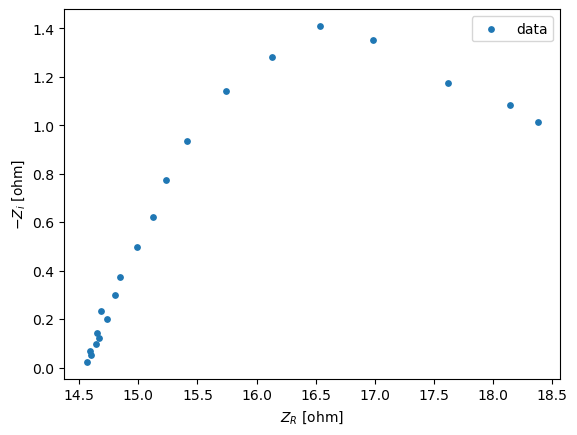

In [18]:
plot_sample_exp(df_PEIS, exp_type="PEIS", sample_id=0, plt_type="scatter", 
            par_df=output_Nyquist, par_list=["Rs/ohm", "Rct/ohm"])

Rs/ohm = 14.56397
Rct/ohm = 4.368609152249978


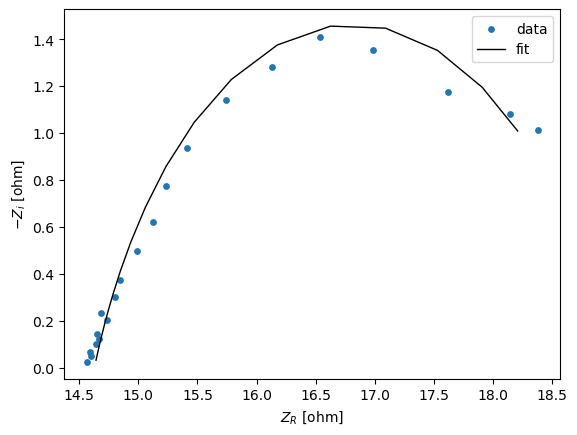

In [19]:
plot_sample_exp(df_PEIS, exp_type="PEIS", sample_id=0,fit_array=output_Nyquist['Nyquist_fit'], plt_type="scatter", 
            par_df=output_Nyquist, par_list=["Rs/ohm", "Rct/ohm"])


## 2. OCV

In [20]:
def get_OCV(df, fltr='time/s', x='time/s', y='Ewe/V', colname='OCV'):
    
    start, i = 0 ,0
    df_new = pd.DataFrame(columns=[colname], dtype=object)
    
    # Use abrupt chnage in V as an indicator for OCV pieces
    df['indicator'] = [0] + list(df[fltr].values[1:] - df[fltr].values[:-1])
    df['indicator'] = df['indicator'].apply(lambda x: abs(x) > 1.0)
    indicators_list= np.argwhere((df['indicator']==True).values)[:,0]
    indicators_list= np.append(indicators_list, 0)
    
    for end in indicators_list:
        if i==len(indicators_list)-1:
            end=df.shape[0]-1
        try:
            t0=df.iloc[start:end][x][start]    
        except:
            print('Error')
            break
        OCV_array = np.column_stack((df.iloc[start:end][x]-t0, df.iloc[start:end][y]))
        df_new.loc[i, colname]= OCV_array
        start = end+1
        i+=1
            
    return df_new    

In [21]:
def process_OCV(df):
    df = df.applymap(lambda x: x[:,1][-1])
    df = df.rename({'OCV': 'ocv/V'}, axis='columns')
    return df

In [22]:
df = read_mpr(file_list, exp_id, technique='OCV')
df_OCV = get_OCV(df)
df_OCV

,OCV
0,"[[0.0, 0.5554196834564209], [0.999999974737875..."
1,"[[0.0, 0.658349871635437], [0.9999999747378752..."
2,"[[0.0, 0.540639340877533], [0.9999999747378752..."
3,"[[0.0, 0.5449346899986267], [0.999999974737875..."
4,"[[0.0, 0.6184512376785278], [0.999999974737875..."
5,"[[0.0, 0.5771971940994263], [0.999999987892806..."
6,"[[0.0, 0.6353269815444946], [0.999999987892806..."
7,"[[0.0, 0.6651268601417542], [0.999999987892806..."
8,"[[0.0, 0.5747154355049133], [0.999999987892806..."
9,"[[0.0, 0.5857686996459961], [0.999999987892806..."


In [23]:
output_OCV=process_OCV(df_OCV)
output_OCV

,ocv/V
0,0.552823
1,0.660908
2,0.543217
3,0.547512
4,0.619692
5,0.575670
6,0.636816
7,0.666425
8,0.575937
9,0.586876


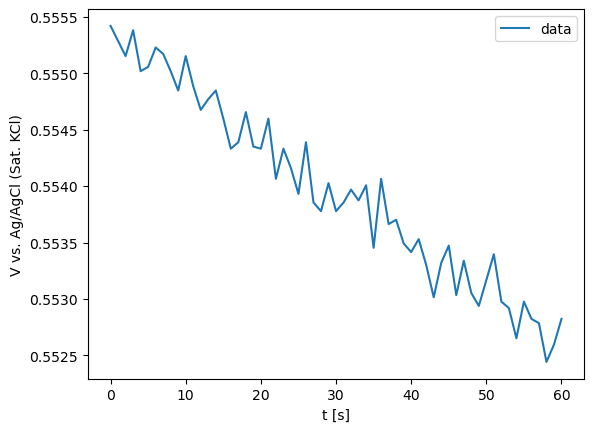

In [24]:
plot_sample_exp(df_OCV, exp_type="OCV", sample_id=0, plt_type="line")

## 3. CV

In [25]:
def get_CV(df, fltr1='cycle number', reps=cva_reps, colname='CVA', x='Ewe/V', y='I/mA', z=v_sweep):
    
    #initiate empty df for CVA
    df_new = pd.DataFrame(columns=[colname], dtype=object)
    z=np.array(z)
    
    #select the last rep for each sample
    df=df[df[fltr1]%reps==0]
    df = df.reset_index()
    sample_no=max(df[fltr1].unique())/reps/len(z)
    df[fltr1]=df[fltr1]/reps
    
    for sample in range(0,int(sample_no)):
        start = sample*len(z)+1
        end = (sample+1)*len(z)+1
        sample_indx= np.argwhere(( (df[fltr1]<end) & (df[fltr1]>(start-1))).values)[:,0]
        df_cv = df.loc[sample_indx[0]:sample_indx[-1]]
        
        
        if len(z)>1:
            l= np.array(df_cv[fltr1]-start).astype(int)
            Z = z[l]
            CV_array=np.column_stack((df_cv[x], df_cv[y], Z))
        else:
            CV_array=np.column_stack((df_cv[x], df_cv[y]))
        
        df_new.loc[sample, colname]= CV_array

    return df_new

In [26]:
df = read_mpr(file_list, exp_id, technique='CV')
df_CV = get_CV(df, reps=cv_reps, colname='CV', z=[50])
df_CV

,CV
0,"[[-0.0005265934742055833, -2.4234264254983913]..."
1,"[[-0.0005501659470610321, -0.4112221646743519]..."
2,"[[-0.0005798618658445776, -0.9464950370084928]..."
3,"[[-0.0006922822794876993, -0.28131156562206616..."
4,"[[-0.000584104098379612, -0.7277679476473058],..."
5,"[[-0.0005162277375347912, -0.1433909213325626]..."
6,"[[-0.0006053155520930886, -5.489560120635558],..."
7,"[[-0.0005872859037481248, -7.8050297655992935]..."
8,"[[-0.0005469841999001801, -2.537126122663416],..."
9,"[[-0.0005183488829061389, -1.9729679340703612]..."


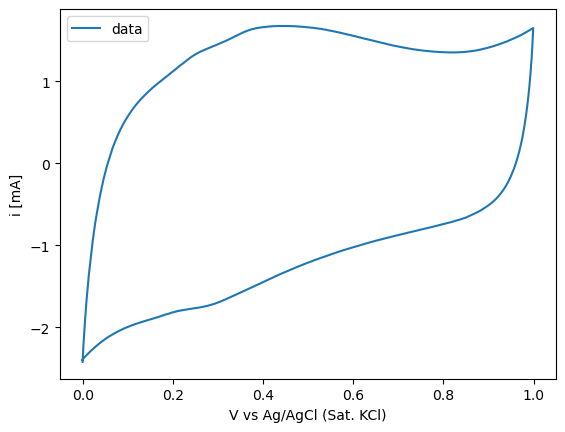

In [27]:
plot_sample_exp(df_CV, exp_type="CV", sample_id=0, plt_type="line")

## 4. ECSA

In [28]:
def get_Cdl(x, v_sweep, Cs=0.04, geo_area=geo_area):
    avg_I=[]
    s=x[:,2]
    v_sweep = np.array(v_sweep)
    
    for speed in v_sweep:
        V=x[:,0]
        I=x[:,1]
        loc_list=np.argwhere(s==speed)[:,0]
        V = V[loc_list]
        I = I[loc_list]
        vrange = V.max()-V.min()
        ocv = (V.max()+V.min())/2
        # current = area / x-range
        hull = ConvexHull(np.column_stack((V,I)))
        avg_I.append(hull.volume/(vrange))
    
    avg_I= np.array(avg_I)
    
    cdl_fit= np.polyfit(v_sweep,avg_I, deg=1)
    cdl = cdl_fit[0]*1000 #millifarads
    Cdl_line=(cdl_fit[0]*v_sweep)+cdl_fit[1]
    Cdl_array = np.column_stack((v_sweep,avg_I))
    Cdl_fit = np.column_stack((v_sweep,Cdl_line))
    
    ECSA= cdl/Cs
    RF=ECSA/geo_area
    return Cdl_array, Cdl_fit, cdl, ECSA, RF

In [29]:
def process_Cdl(input_df, v_sweep, Cs=0.04, geo_area=geo_area):
    df= input_df.applymap(lambda x: get_Cdl(x, v_sweep, Cs, geo_area))
    df[['Cdl', 'Cdl_fit', 'Cdl/mF', 'ECSA/cm2', 'RF']] = pd.DataFrame(df['CVA'].tolist())
    df = df.drop(['CVA'], axis=1) #Cleaning output dfs
    return df

In [30]:
df = read_mpr(file_list, exp_id, technique='CVA')
df_CVA = get_CV(df, reps=cva_reps, colname='CVA', z=v_sweep)
df_CVA

,CVA
0,"[[0.5013942718505859, -0.41875557465986724, 20..."
1,"[[0.6099605560302734, -0.0432729358700189, 20...."
2,"[[0.4924600422382355, -0.06223340891301654, 20..."
3,"[[0.4966980814933777, -0.050009423528205366, 2..."
4,"[[0.5685728788375854, -0.10112868215550075, 20..."
5,"[[0.5247607827186584, -0.025228975594721065, 2..."
6,"[[0.5859068036079407, -0.9483737620440387, 20...."
7,"[[0.615382194519043, -1.8698964660817907, 20.0..."
8,"[[0.524913489818573, -0.645416796207428, 20.0]..."
9,"[[0.5358904004096985, -0.4970492016185428, 20...."


In [31]:
output_ECSA = process_Cdl(df_CVA, v_sweep=v_sweep[:], Cs=Cs)
output_ECSA

,Cdl,Cdl_fit,Cdl/mF,ECSA/cm2,RF
0,"[[20.0, 0.5970556758215524], [40.0, 0.91800807...","[[20.0, 0.6888630738421992], [40.0, 0.85864260...",8.488976,141.482939,721.851730
1,"[[20.0, 0.07606454838500248], [40.0, 0.1252397...","[[20.0, 0.08189004444085426], [40.0, 0.1217423...",1.992618,33.210295,169.440282
2,"[[20.0, 0.13118980755776097], [40.0, 0.2356083...","[[20.0, 0.14367324276555868], [40.0, 0.2290219...",4.267435,71.123925,362.877167
3,"[[20.0, 0.10391163978991942], [40.0, 0.1838370...","[[20.0, 0.11172961033149424], [40.0, 0.1796171...",3.394378,56.572958,288.637543
4,"[[20.0, 0.1505053738886394], [40.0, 0.23871849...","[[20.0, 0.16277922612816367], [40.0, 0.2312538...",3.423733,57.062223,291.133790
5,"[[20.0, 0.04085371083480769], [40.0, 0.0634837...","[[20.0, 0.043682324540894144], [40.0, 0.061614...",0.896592,14.943201,76.240823
6,"[[20.0, 1.2583022450057497], [40.0, 1.54734471...","[[20.0, 1.4266131606153278], [40.0, 1.40021361...",-1.319977,-21.999624,-112.242981
7,"[[20.0, 1.3660032713691275], [40.0, 1.07880774...","[[20.0, 1.286193745979374], [40.0, 1.127007110...",-7.959332,-132.655530,-676.813926
8,"[[20.0, 0.9804317065950741], [40.0, 1.42844929...","[[20.0, 1.1745740496595984], [40.0, 1.28899178...",5.720887,95.348109,486.469946
9,"[[20.0, 0.7839543212618799], [40.0, 1.23632337...","[[20.0, 0.9492006729923872], [40.0, 1.13161241...",9.120587,152.009781,775.560109


Cdl/mF = 8.488976347921298
ECSA/cm2 = 141.48293913202164
RF = 721.8517302654166


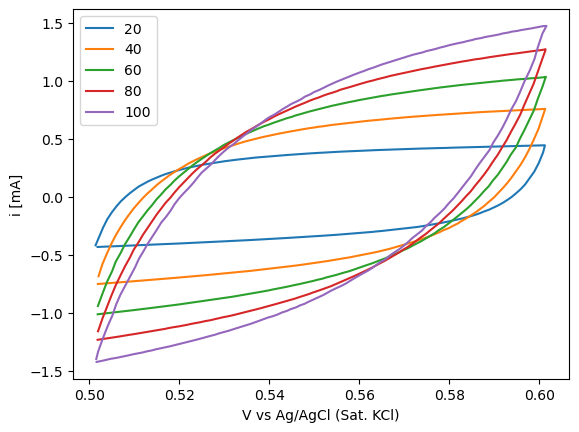

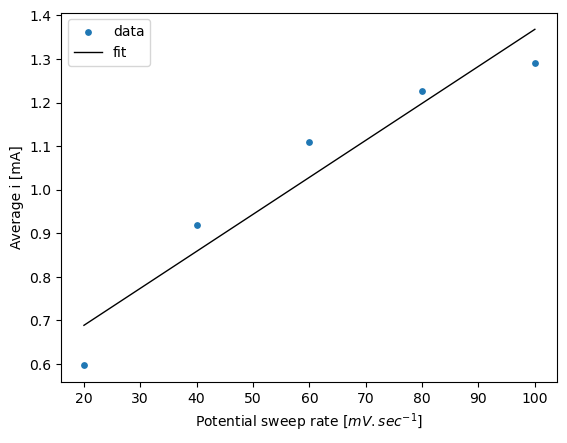

In [32]:
plot_sample_exp(df_CVA, exp_type="CVA", sample_id=0, plt_type="line", reps=True)
plot_sample_exp(output_ECSA, exp_type="Cdl", fit_array=output_ECSA['Cdl_fit'], sample_id=0, plt_type="scatter",
            par_df=output_ECSA, par_list=["Cdl/mF","ECSA/cm2", "RF"])

## Polarization curves

In [33]:
def get_LSV(df, fltr1='I/mA', x='Ewe/V', y='I/mA', z=LSV_reps, colname='LSV', avg_col=[]):
    
    start=0
    i=1
    LSV_no=0
    
    df_new = pd.DataFrame(columns=[colname] ,dtype=object)
    df['indicator'] = list(df[fltr1])
    df['indicator'] = df['indicator'].apply(lambda x: x ==0)
    indicators_list=np.argwhere((df['indicator']==True).values)[:,0]
    
    for end in indicators_list:
        if i==len(indicators_list):
            end = df.shape[0]-1
        if not start==end:
            df_sel = df.iloc[start:end]
            
            if len(avg_col)==2:
                df_sel = df_sel.groupby(y)[x].mean().reset_index()
        
            if (LSV_no+z)%z==0:
                rep=1
                LSV_array =  np.column_stack((df_sel[x], df_sel[y], np.full(df_sel.shape[0],rep)))
            else:
                rep+=1
                LSV_array = np.row_stack((LSV_array,(np.column_stack((df_sel[x], df_sel[y], np.full(df_sel.shape[0],rep))))))
            
            LSV_array = LSV_array[np.where(LSV_array[:,1]>=0)]
            df_new.loc[math.floor(LSV_no/z), colname]= LSV_array
            
            LSV_no+=1
            
        i+=1
        start = end+1
    
    return df_new

In [34]:
def convert_RHE(x, R, ref_pot, pH):
    
    V=x[:,0]
    I=x[:,1]
    
    if R>100:
        R = 0 # replace high R with 0
    
    V = V-(R*I/1000)+ref_pot+pH*0.059
    
    return V

In [35]:
def convert_j(x, A, ecsa=False):
    V=x[:,0]
    I=x[:,1]
    J=I/A
    return J

In [36]:
def cal_op(V,I, j_target):
    if j_target>I[-1]:
        return np.nan
    else:
        return round(np.interp(j_target,  I,V-1.23),3)

In [37]:
def cal_jecsa(V,I, p_target):
    if p_target>V[-1]:
        return np.nan
    else:
        return round(np.interp(p_target+1.23,  V,I),3)

In [38]:
def apply_stats(df):
    df_new = pd.DataFrame()
    for col in df.columns:
        df_new[col+'_mean'] = df[col].apply(lambda x: np.nan if True in np.isnan(x) else np.mean(x) )
        df_new[col+'_std']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else np.std(x) )
        df_new[col+'_max']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else np.max(x))
        df_new[col+'_min']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else np.min(x))
        df_new[col+'_range']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else np.max(x)-np.min(x))
        df_new[col+'_i']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else x[0])
        df_new[col+'_f']=df[col].apply(lambda x: np.nan if True in np.isnan(x) else x[-1] )
    return df_new

In [39]:
def cal_tafel(op1, op2, j1=1, j2=10):
    tafel = op2-op1/(np.log10(j2)-np.log10(j1))
    return tafel

In [40]:
def tafel_plot(V, I, z):
    Ilog = np.log10(I)
    tafel_array =  np.column_stack((Ilog, V, z)) #np.full(len(V),z)
    return tafel_array

In [41]:
def analyze_LSV(x, R, ref_pot, pH, geo_area, ECSA):
    
    #Add processed LSV curves
    VRHE=convert_RHE(x, R, ref_pot, pH)
    J=convert_j(x, geo_area)
    Jecsa=convert_j(x, ECSA)
    LSV_RHE=np.column_stack((VRHE, J, x[:,2]))
    LSV_ECSA=np.column_stack((VRHE, Jecsa, x[:,2]))
    Tafel_plot = tafel_plot(VRHE, J, x[:,2])
    
    i=0
    OP1=[]
    OP10=[]
    Tafel=[]
    JECSA=[]
    Tafel_3=[]
    while i<max(x[:,2]):
        loc_list=np.argwhere(x[:,2]==i+1)[:,0]
        VRHE_rep= VRHE[loc_list]
        Jecsa_rep= Jecsa[loc_list]
        J_rep = J[loc_list]
        op1=cal_op(VRHE_rep, J_rep, 1)
        op10=cal_op(VRHE_rep, J_rep, 10)
        tafel=cal_tafel(op1, op10, 1, 10)
        jecsa=cal_jecsa(VRHE_rep, Jecsa_rep, 0.3)
        tafel_3=cal_tafel(cal_op(VRHE_rep, J_rep, 3), cal_op(VRHE_rep, J_rep, 30), 3, 30)
        
        
        #Add extracted values to list/array
        OP1.append(op1)
        OP10.append(op10)
        Tafel.append(tafel)
        JECSA.append(jecsa)
        Tafel_3.append(tafel_3)
        
        i+=1

    return LSV_RHE, LSV_ECSA, Tafel_plot, OP1, OP10, Tafel, JECSA, Tafel_3

In [42]:
def LSV_analysis(df, R, ref_pot, pH, geo_area, ECSA, colname='LSV', do_stats=True):
    data=[]
    for i, LSV in enumerate(df[colname]):
        data.append(analyze_LSV(LSV, R[i], ref_pot, pH, geo_area, ECSA[i]))
    
    output_df = pd.DataFrame(data, columns=[colname+'_RHE',colname+'_ECSA', colname+'_Tafel', colname+'_OP1mAcm-2/V', colname+'_OP10mAcm-2/V', colname+'_Tafel/Vdec-1', colname+'_jecsa0.3V/mAcm-2', colname+'_Tafel3/Vdec-1'])
    if do_stats:
        stats = apply_stats(output_df.iloc[:,3:])
        output_df = pd.concat([output_df, stats],axis=1)
    return output_df

## 5. Polarization curve-CP

In [43]:
filename = get_mpr_name(file_list, exp_id, technique='CP', ext='.txt')
df = pd.read_csv(filename, delimiter='\t')
df = df.drop(df.columns[-1], axis=1)
df

,control/mA,<Ewe>/V
0,0.00,1.200811
1,0.00,1.196304
2,0.00,1.190125
3,0.00,1.185782
4,0.00,1.182389
...,...,...
18865,0.02,1.086900
18866,0.02,1.086919
18867,0.02,1.086921
18868,0.02,1.086919


In [44]:
df_pol_cp= get_LSV(df, fltr1='control/mA', x='<Ewe>/V', y='control/mA', z=1, colname='pol_cp', avg_col=['control/mA','<Ewe>/V'])
df_pol_cp

,pol_cp
0,"[[1.1040576370915032, 0.02, 1.0]]"
1,"[[1.0879005123093681, 0.02, 1.0]]"
2,"[[1.0959673163398693, 0.02, 1.0]]"
3,"[[1.1433536236928106, 0.02, 1.0]]"
4,"[[1.1348287547385623, 0.02, 1.0]]"
5,"[[1.0916517331154685, 0.02, 1.0]]"
6,"[[1.08845433583878, 0.02, 1.0]]"
7,"[[1.0771180376361655, 0.02, 1.0]]"
8,"[[1.1050608061002178, 0.02, 1.0]]"
9,"[[1.1425691, 0.0, 1.0], [1.0932514097547685, 0..."


In [45]:
R = output_Nyquist['Rs/ohm']
ECSA = output_ECSA['ECSA/cm2']
output_pol_cp = LSV_analysis(df_pol_cp, R, ref_pot, pH, geo_area, ECSA, colname='pol_cp', do_stats=False)
output_pol_cp

,pol_cp_RHE,pol_cp_ECSA,pol_cp_Tafel,pol_cp_OP1mAcm-2/V,pol_cp_OP10mAcm-2/V,pol_cp_Tafel/Vdec-1,pol_cp_jecsa0.3V/mAcm-2,pol_cp_Tafel3/Vdec-1
0,"[[1.3037663576992606, 0.10204081632653061, 1.0]]","[[1.3037663576992606, 0.00014135980014761673, ...","[[-0.9912260756924949, 1.3037663576992606, 1.0]]",[nan],[nan],[nan],[0.0],[nan]
1,"[[1.2875744309189872, 0.10204081632653061, 1.0]]","[[1.2875744309189872, 0.0006022228888286052, 1...","[[-0.9912260756924949, 1.2875744309189872, 1.0]]",[nan],[nan],[nan],[0.001],[nan]
2,"[[1.2956709941657971, 0.10204081632653061, 1.0]]","[[1.2956709941657971, 0.0002811993303897552, 1...","[[-0.9912260756924949, 1.2956709941657971, 1.0]]",[nan],[nan],[nan],[0.0],[nan]
3,"[[1.343054522855103, 0.10204081632653061, 1.0]]","[[1.343054522855103, 0.00035352579308740715, 1...","[[-0.9912260756924949, 1.343054522855103, 1.0]]",[nan],[nan],[nan],[0.0],[nan]
4,"[[1.334526248062842, 0.10204081632653061, 1.0]]","[[1.334526248062842, 0.0003504945824821336, 1.0]]","[[-0.9912260756924949, 1.334526248062842, 1.0]]",[nan],[nan],[nan],[0.0],[nan]
5,"[[1.291321065429006, 0.10204081632653061, 1.0]]","[[1.291321065429006, 0.0013384013042519259, 1.0]]","[[-0.9912260756924949, 1.291321065429006, 1.0]]",[nan],[nan],[nan],[0.001],[nan]
6,"[[1.2881619218792768, 0.10204081632653061, 1.0]]","[[1.2881619218792768, -0.0009091064363524226, ...","[[-0.9912260756924949, 1.2881619218792768, 1.0]]",[nan],[nan],[nan],[-0.001],[nan]
7,"[[1.2768213843082237, 0.10204081632653061, 1.0]]","[[1.2768213843082237, -0.0001507664254270391, ...","[[-0.9912260756924949, 1.2768213843082237, 1.0]]",[nan],[nan],[nan],[-0.0],[nan]
8,"[[1.3047674328778667, 0.10204081632653061, 1.0]]","[[1.3047674328778667, 0.00020975769852127926, ...","[[-0.9912260756924949, 1.3047674328778667, 1.0]]",[nan],[nan],[nan],[0.0],[nan]
9,"[[1.3425691, 0.0, 1.0], [1.2929625694227371, 0...","[[1.3425691, 0.0, 1.0], [1.2929625694227371, 0...","[[-inf, 1.3425691, 1.0], [-0.9912260756924949,...",[nan],[nan],[nan],[0.0],[nan]


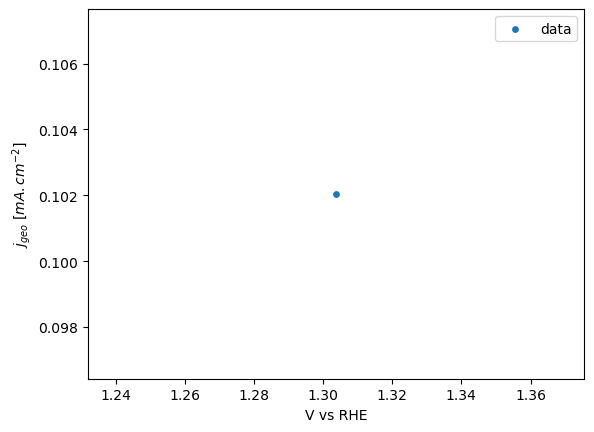

In [46]:
plot_sample_exp(output_pol_cp, exp_type="pol_cp_RHE", sample_id=0, plt_type="scatter", reps=False)

## 6. LSV

In [47]:
df = read_mpr(file_list, exp_id, technique='LSV')
df

,flags,time/s,control/V,Ewe/V,I/mA,(Q-Qo)/C,I Range
0,23,469.501989,0.000000,1.104814,0.000000,4.624681e-09,14
1,7,474.501789,0.799974,1.098495,0.000000,4.624681e-09,11
2,18,474.521789,0.800024,0.798969,-17.127980,-3.586043e-04,11
3,18,474.631789,0.800574,0.799379,-9.620052,-1.509192e-03,11
4,18,474.831789,0.801573,0.800426,-4.219072,-2.843115e-03,11
...,...,...,...,...,...,...,...
19615,6,8868.199651,1.446409,1.445230,14.481970,3.574149e-01,11
19616,22,8868.399551,1.447408,1.446270,14.546911,3.603170e-01,11
19617,22,8868.599451,1.448409,1.447205,14.607338,3.632317e-01,11
19618,22,8868.799451,1.449408,1.448249,14.669721,3.661600e-01,11


In [48]:
df_LSV= get_LSV(df)
df_LSV 

,LSV
0,"[[0.8395043015480042, 0.0013020316955424834, 1..."
1,"[[0.8734488487243652, 0.000570510169947767, 1...."
2,"[[0.8183652758598328, 0.0005506298573622454, 1..."
3,"[[0.8354678750038147, 0.00012863211049303578, ..."
4,"[[0.8704209327697754, 0.0012796036500520754, 1..."
5,"[[0.888387143611908, 0.00014904093887767702, 1..."
6,"[[0.8263989686965942, 0.011942962596605655, 1...."
7,"[[0.8513648509979248, 0.014960517816641927, 1...."
8,"[[0.8244284987449646, 0.008568946430038318, 1...."
9,"[[0.8173936605453491, 0.01550643578107841, 1.0..."


In [49]:
R = output_Nyquist['Rs/ohm']
ECSA = output_ECSA['ECSA/cm2']
output_LSV = LSV_analysis(df_LSV, R, ref_pot, pH, geo_area, ECSA)
output_LSV

,LSV_RHE,LSV_ECSA,LSV_Tafel,LSV_OP1mAcm-2/V,LSV_OP10mAcm-2/V,LSV_Tafel/Vdec-1,LSV_jecsa0.3V/mAcm-2,LSV_Tafel3/Vdec-1,LSV_OP1mAcm-2/V_mean,LSV_OP1mAcm-2/V_std,...,LSV_jecsa0.3V/mAcm-2_range,LSV_jecsa0.3V/mAcm-2_i,LSV_jecsa0.3V/mAcm-2_f,LSV_Tafel3/Vdec-1_mean,LSV_Tafel3/Vdec-1_std,LSV_Tafel3/Vdec-1_max,LSV_Tafel3/Vdec-1_min,LSV_Tafel3/Vdec-1_range,LSV_Tafel3/Vdec-1_i,LSV_Tafel3/Vdec-1_f
0,"[[1.0394853387979563, 0.006643018854808588, 1....","[[1.0394853387979563, 9.2027470133874e-06, 1.0...","[[-2.177634514903369, 1.0394853387979563, 1.0]...","[0.12, 0.128, 0.133]","[0.181, 0.188, 0.19]","[0.061, 0.06, 0.056999999999999995]","[0.087, 0.083, 0.085]","[0.05099999999999999, 0.057999999999999996, 0....",0.127000,0.005354,...,0.004,0.087,0.085,0.055333,0.003091,0.058,0.051,0.007,0.051,0.057
1,"[[1.0734395470868932, 0.0029107661732028925, 1...","[[1.0734395470868932, 1.717871413260214e-05, 1...","[[-2.5359926807743207, 1.0734395470868932, 1.0...","[0.159, 0.174, 0.18]","[0.228, 0.254, 0.266]","[0.069, 0.08000000000000002, 0.08600000000000002]","[0.174, 0.127, 0.106]","[0.11299999999999999, nan, nan]",0.171000,0.008832,...,0.068,0.174,0.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[[1.0183571176680106, 0.0028093360069502316, 1...","[[1.0183571176680106, 7.741837359143491e-06, 1...","[[-2.551396314469701, 1.0183571176680106, 1.0]...","[0.145, 0.155, 0.166]","[0.206, 0.215, 0.224]","[0.061, 0.06, 0.057999999999999996]","[0.15, 0.134, 0.12]","[0.061, 0.065, 0.07400000000000001]",0.155333,0.008576,...,0.030,0.150,0.120,0.066667,0.005437,0.074,0.061,0.013,0.061,0.074
3,"[[1.0354659513052145, 0.0006562862780256927, 1...","[[1.0354659513052145, 2.273738443927873e-06, 1...","[[-3.1829066761027036, 1.0354659513052145, 1.0...","[0.17, 0.173, 0.175]","[0.227, 0.234, 0.238]","[0.056999999999999995, 0.061000000000000026, 0...","[0.152, 0.146, 0.142]","[0.07400000000000001, 0.07800000000000001, 0.0...",0.172667,0.002055,...,0.010,0.152,0.142,0.077333,0.002494,0.080,0.074,0.006,0.074,0.080
4,"[[1.0704015783374545, 0.0065285900512860985, 1...","[[1.0704015783374545, 2.242470735338082e-05, 1...","[[-2.185180601123514, 1.0704015783374545, 1.0]...","[0.158, 0.163, 0.166]","[0.22, 0.227, 0.232]","[0.062, 0.064, 0.066]","[0.165, 0.158, 0.152]","[0.065, 0.07, 0.07300000000000001]",0.162333,0.003300,...,0.013,0.165,0.152,0.069333,0.003300,0.073,0.065,0.008,0.065,0.073
5,"[[1.0883846794607857, 0.0007604129534575357, 1...","[[1.0883846794607857, 9.973829349040724e-06, 1...","[[-3.1189504936382444, 1.0883846794607857, 1.0...","[0.192, 0.2, 0.205]","[0.277, 0.3, 0.311]","[0.08500000000000002, 0.09999999999999998, 0.1...","[0.187, 0.13, 0.111]","[nan, nan, nan]",0.199000,0.005354,...,0.076,0.187,0.111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[[1.0262243542475407, 0.060933482635743136, 1....","[[1.0262243542475407, -0.0005428712082845222, ...","[[-1.2151439991894657, 1.0262243542475407, 1.0...","[-0.196, -0.168, -0.175]","[0.155, 0.158, 0.161]","[0.351, 0.326, 0.33599999999999997]","[-0.68, -0.673, -0.668]","[0.074, 0.077, 0.071]",-0.179667,0.011898,...,0.012,-0.680,-0.668,0.074000,0.002449,0.077,0.071,0.006,0.074,0.071
7,"[[1.0511429466280229, 0.07632917253388738, 1.0...","[[1.0511429466280229, -0.00011277718968763174,...","[[-1.117309445674404, 1.0511429466280229, 1.0]...","[-0.177, -0.162, -0.162]","[0.133, 0.146, 0.15]","[0.31, 0.308, 0.312]","[-0.109, -0.107, -0.105]","[0.33699999999999997, 0.32399999999999995, 0.3...",-0.167000,0.007071,...,0.004,-0.109,-0.105,0.329000,0.005715,0.337,0.324,0.013,0.337,0.326
8,"[[1.024302803773648, 0.04371911443897101, 1.0]...","[[1.024302803773648, 8.98701240958485e-05, 1.0...","[[-1.3593286435696212, 1.024302803773648, 1.0]...","[-0.172, -0.159, -0.157]","[0.173, 0.177, 0.179]","[0.345, 0.33599999999999997, 0.33599999999999997]","[0.143, 0.142, 0.141]","[0.05500000000000002, 0.05400000000000002, 0.0...",-0.162667,0.006650,...,0.002,0.143,0.141,0.054333,0.000471,0.055,0.054,0.001,0.055,0.054
9,"[[1.0171697163423676, 0.0791144682708082, 1.0]...",

LSV_OP1mAcm-2/V = [0.12, 0.128, 0.133]
LSV_OP10mAcm-2/V = [0.181, 0.188, 0.19]
LSV_Tafel/Vdec-1 = [0.061, 0.06, 0.056999999999999995]
LSV_jecsa0.3V/mAcm-2 = [0.087, 0.083, 0.085]


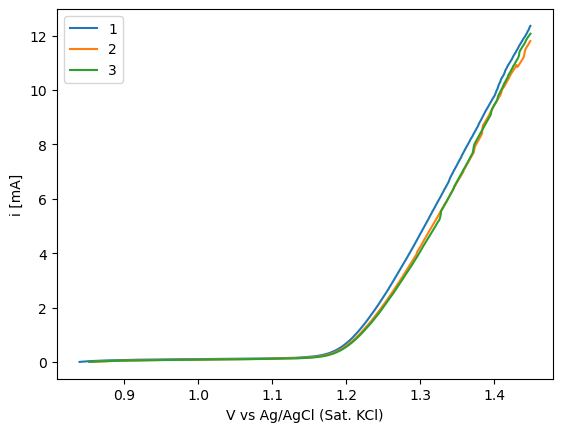

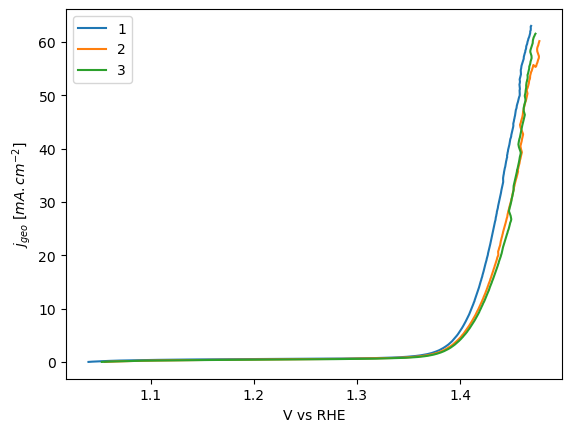

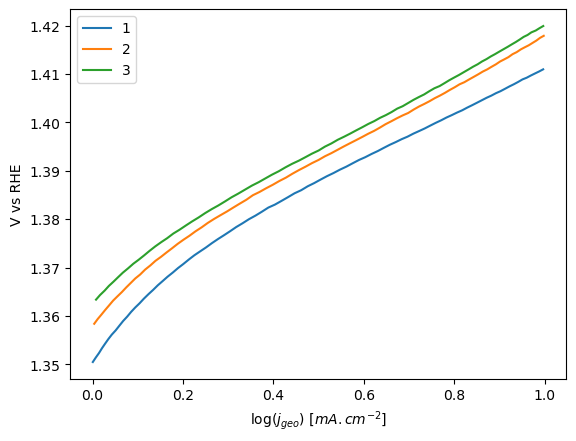

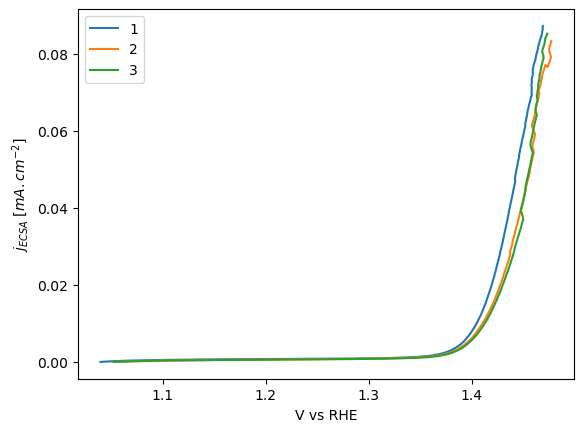

In [50]:
plot_sample_exp(df_LSV, exp_type="LSV", sample_id=0, plt_type="line", reps=True)
plot_sample_exp(output_LSV, exp_type="LSV_RHE", sample_id=0, plt_type="line", reps=True, 
            par_df=output_LSV, par_list=["LSV_OP1mAcm-2/V", "LSV_OP10mAcm-2/V"])
plot_sample_exp(output_LSV, exp_type="LSV_Tafel", sample_id=0, plt_type="line", reps=True, xrange=[0,1],
           par_df=output_LSV, par_list=["LSV_Tafel/Vdec-1"])
plot_sample_exp(output_LSV, exp_type="LSV_ECSA", sample_id=0, plt_type="line", reps=True,
            par_df=output_LSV, par_list=["LSV_jecsa0.3V/mAcm-2"])

## Results

In [51]:
def export_df(df, output_dir=output_dir, exp_id=exp_id):
    filename=output_dir+exp_id+'-EC_results.xlsx'
    writer = pd.ExcelWriter(filename)
    df.to_excel(writer)
    writer.save()
    return df

In [52]:
results = pd.concat([df_OCV, df_CV, df_PEIS, df_CVA, df_LSV, output_OCV, output_Nyquist, output_ECSA, output_pol_cp,output_LSV], axis=1)
export_df(results)

,OCV,CV,PEIS,CVA,LSV,ocv/V,Nyquist_fit,Rs/ohm,Rct/ohm,Cdl,...,LSV_jecsa0.3V/mAcm-2_range,LSV_jecsa0.3V/mAcm-2_i,LSV_jecsa0.3V/mAcm-2_f,LSV_Tafel3/Vdec-1_mean,LSV_Tafel3/Vdec-1_std,LSV_Tafel3/Vdec-1_max,LSV_Tafel3/Vdec-1_min,LSV_Tafel3/Vdec-1_range,LSV_Tafel3/Vdec-1_i,LSV_Tafel3/Vdec-1_f
0,"[[0.0, 0.5554196834564209], [0.999999974737875...","[[-0.0005265934742055833, -2.4234264254983913]...","[[14.56397, 0.022994597, 2630.8418], [14.58933...","[[0.5013942718505859, -0.41875557465986724, 20...","[[0.8395043015480042, 0.0013020316955424834, 1...",0.552823,"[[14.642479077380518, 0.031239475577188102], [...",14.56397,4.368609,"[[20.0, 0.5970556758215524], [40.0, 0.91800807...",...,0.004,0.087,0.085,0.055333,0.003091,0.058,0.051,0.007,0.051,0.057
1,"[[0.0, 0.658349871635437], [0.9999999747378752...","[[-0.0005501659470610321, -0.4112221646743519]...","[[16.30407, 0.14407115, 27928.299], [16.399664...","[[0.6099605560302734, -0.0432729358700189, 20....","[[0.8734488487243652, 0.000570510169947767, 1....",0.660908,"[[16.73321423462628, 0.17965621820245703], [16...",16.30407,14.724033,"[[20.0, 0.07606454838500248], [40.0, 0.1252397...",...,0.068,0.174,0.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[[0.0, 0.540639340877533], [0.9999999747378752...","[[-0.0005798618658445776, -0.9464950370084928]...","[[14.758967, 0.048255496, 12702.271], [14.8161...","[[0.4924600422382355, -0.06223340891301654, 20...","[[0.8183652758598328, 0.0005506298573622454, 1...",0.543217,"[[14.879171318979367, 0.09968411112704066], [1...",14.816109,7.780149,"[[20.0, 0.13118980755776097], [40.0, 0.2356083...",...,0.030,0.150,0.120,0.066667,0.005437,0.074,0.061,0.013,0.061,0.074
3,"[[0.0, 0.5449346899986267], [0.999999974737875...","[[-0.0006922822794876993, -0.28131156562206616...","[[14.955042, 0.049440235, 8572.047], [14.97933...","[[0.4966980814933777, -0.050009423528205366, 2...","[[0.8354678750038147, 0.00012863211049303578, ...",0.547512,"[[15.180219882980039, 0.0476272159411281], [15...",14.955042,11.158401,"[[20.0, 0.10391163978991942], [40.0, 0.1838370...",...,0.010,0.152,0.142,0.077333,0.002494,0.080,0.074,0.006,0.074,0.080
4,"[[0.0, 0.6184512376785278], [0.999999974737875...","[[-0.000584104098379612, -0.7277679476473058],...","[[15.125334, 0.00013669602, 5780.5747], [15.19...","[[0.5685728788375854, -0.10112868215550075, 20...","[[0.8704209327697754, 0.0012796036500520754, 1...",0.619692,"[[15.276379105730365, 0.02819564900556723], [1...",15.125334,9.006823,"[[20.0, 0.1505053738886394], [40.0, 0.23871849...",...,0.013,0.165,0.152,0.069333,0.003300,0.073,0.065,0.008,0.065,0.073
5,"[[0.0, 0.5771971940994263], [0.999999987892806...","[[-0.0005162277375347912, -0.1433909213325626]...","[[16.533384, 0.2603453, 41400.684], [16.697039...","[[0.5247607827186584, -0.025228975594721065, 2...","[[0.888387143611908, 0.00014904093887767702, 1...",0.575670,"[[17.39925020019606, 0.2494571880550384], [17....",16.533384,34.667749,"[[20.0, 0.04085371083480769], [40.0, 0.0634837...",...,0.076,0.187,0.111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[[0.0, 0.6353269815444946], [0.999999987892806...","[[-0.0006053155520930886, -5.489560120635558],...","[[14.620698, 0.006798272, 3901.2485], [14.6929...","[[0.5859068036079407, -0.9483737620440387, 20....","[[0.8263989686965942, 0.011942962596605655, 1....",0.636816,"[[14.705112865563063, 0.003739468162156227], [...",14.620698,3.152742,"[[20.0, 1.2583022450057497], [40.0, 1.54734471...",...,0.012,-0.680,-0.668,0.074000,0.002449,0.077,0.071,0.006,0.074,0.071
7,"[[0.0, 0.6651268601417542], [0.999999987892806...","[[-0.0005872859037481248, -7.8050297655992935]...","[[15.137983, 0.020873064, 5780.5747], [15.0832...","[[0.615382194519043, -1.8698964660817907, 20.0...","[[0.8513648509979248, 0.014960517816641927, 1....",0.666425,"[[15.15001462409446, 0.00031418293753937245], ...",14.832666,1.316587,"[[20.0, 1.3660032713691275], [40.0, 1.07880774...",...,0.004,-0.109,-0.105,0.329000,0.005715,0.337,0.324,0.013,0.337,0.326
8,"[[0.0, 0.5747154355049133], [0.9

In [53]:
#select samples for plotting

results = results[:] 

## Plots

In [54]:
def plot_layout(df, colname, fig_title, cols=['A','B','C'], font_size=16, plt_type='line',fit=None, cmap='viridis', labels=None, reps=False, ref_electrode=ref_electrode, exp_id=exp_id, output_dir=output_dir, xrange=[], uni_scale=True):
    
    rows = list(range(1,((len(df)-1)//len(cols))+2))
    fig, axs = plt.subplots(len(rows), len(cols), figsize=(10, len(rows)*3), constrained_layout=True)

    xlabel, ylabel = ax_label(colname)

    for i, exp in enumerate(df[colname]):
        if i>len(df):
            break
        
        row=math.ceil((i+1)/len(cols))-1
        col=i%len(cols)
        if len(rows)>1:
            ax = axs[row,col]
        else:
            ax = axs[col]
        ax.set_title(str(cols[col])+str(rows[row]))
        
        fit_array=None
        if fit:
            fit_array= df.loc[i, fit]
        
        try:
            (xmin, xmax), (ymin, ymax) = plot_exp(exp, ax, plt_type, cmap, xrange, fit_array, reps) #plot exp
        except:
            break

        if row==len(rows)-1 and col==math.floor((len(cols))/2):
            ax.set_xlabel(xlabel, fontsize=font_size)
        elif col==0 and row==math.floor((len(rows))/2):
            ax.set_ylabel(ylabel, fontsize=font_size)
        if labels:
            ax.legend(labels)
        
        #set limits for axes
        if i==0:
            Xmin=xmin
            Xmax=xmax
            Ymin=ymin
            Ymax=ymax
        else:
            if xmin<Xmin: Xmin=xmin
            if xmax>Xmax: Xmax=xmax
            if ymax>Ymax: Ymax=ymax
            if ymin<Ymin: Ymin=ymin
    
    xrange=Xmax-Xmin
    yrange=Ymax-Ymin
    
    if uni_scale:
        plt.setp(axs, xlim=[Xmin-0.1*xrange,Xmax+0.1*xrange], ylim=[Ymin-0.1*yrange,Ymax+0.1*yrange])
    fig.suptitle(exp_id + ': ' +fig_title, fontsize=font_size+4)
    
    if output_dir is not None:
        filename=output_dir+exp_id+'-'+fig_title
        fig.savefig(filename)
        

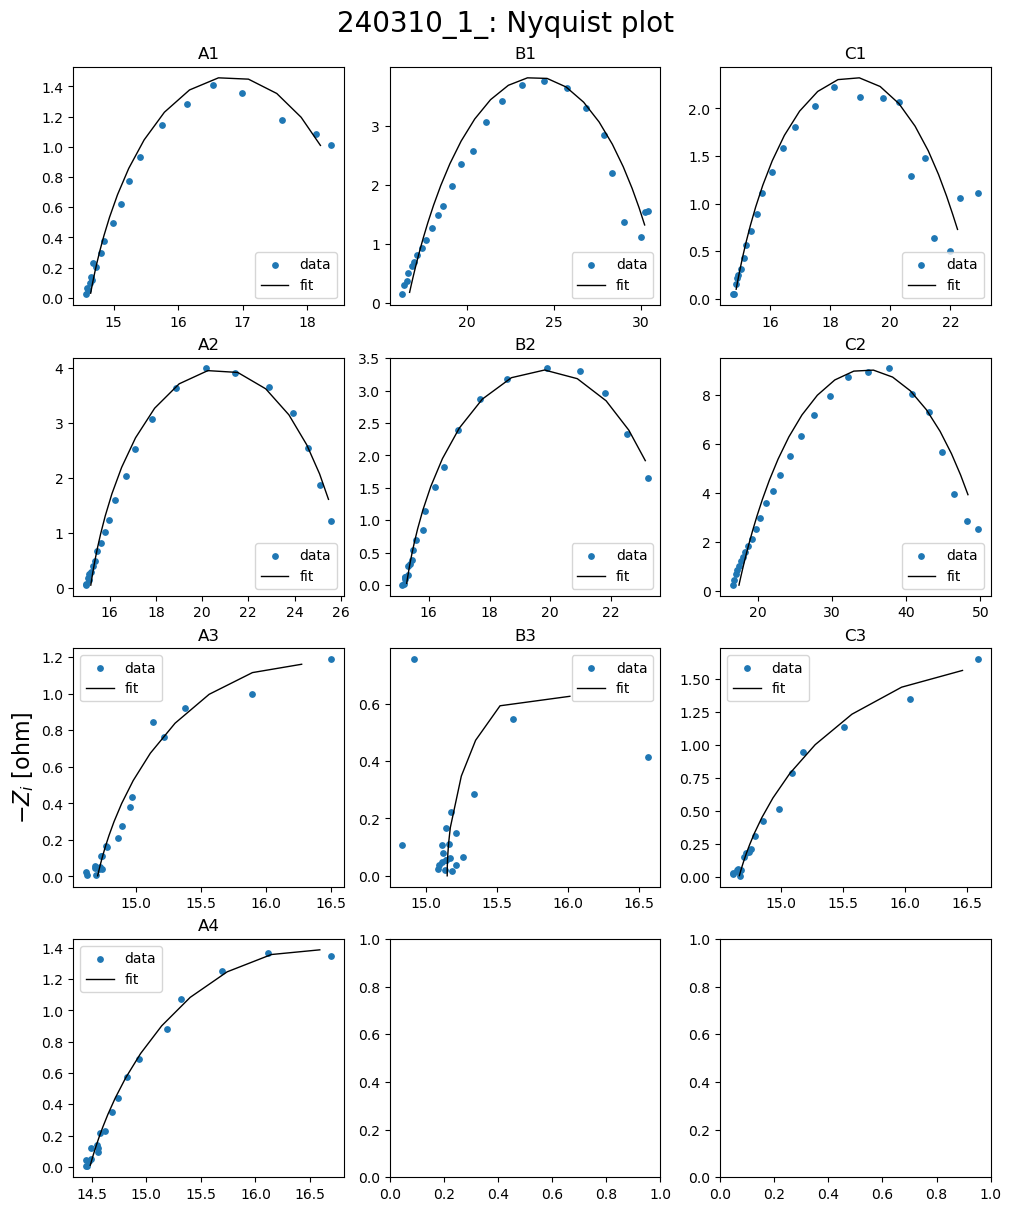

In [55]:
plot_layout(results,colname="PEIS", plt_type='scatter', fig_title='Nyquist plot', uni_scale=False, reps=False, fit='Nyquist_fit')

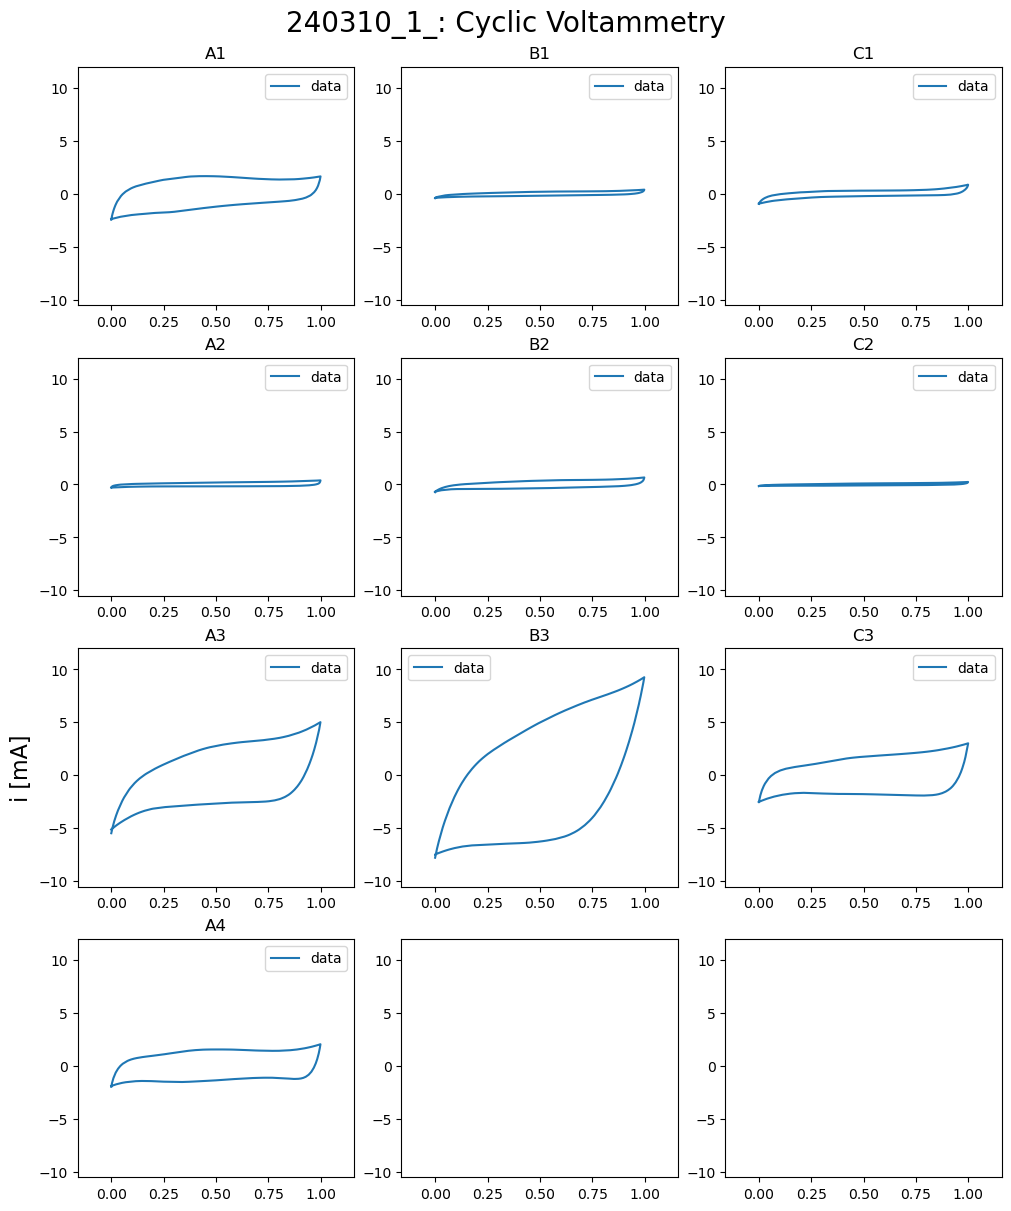

In [56]:
plot_layout(results,colname="CV", fig_title='Cyclic Voltammetry')

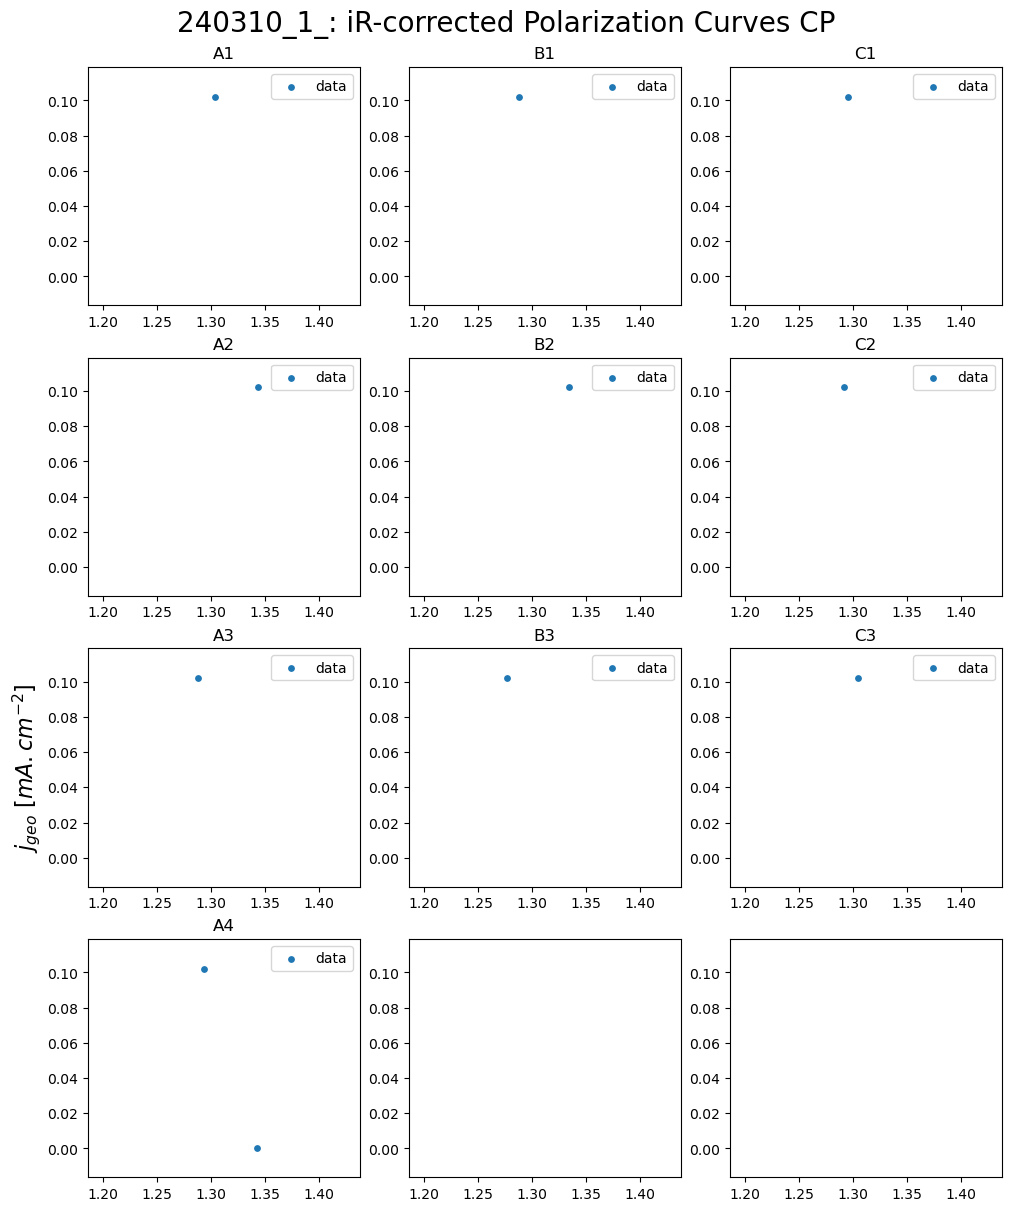

In [57]:
plot_layout(results,colname="pol_cp_RHE", fig_title='iR-corrected Polarization Curves CP', plt_type='scatter', reps=False)

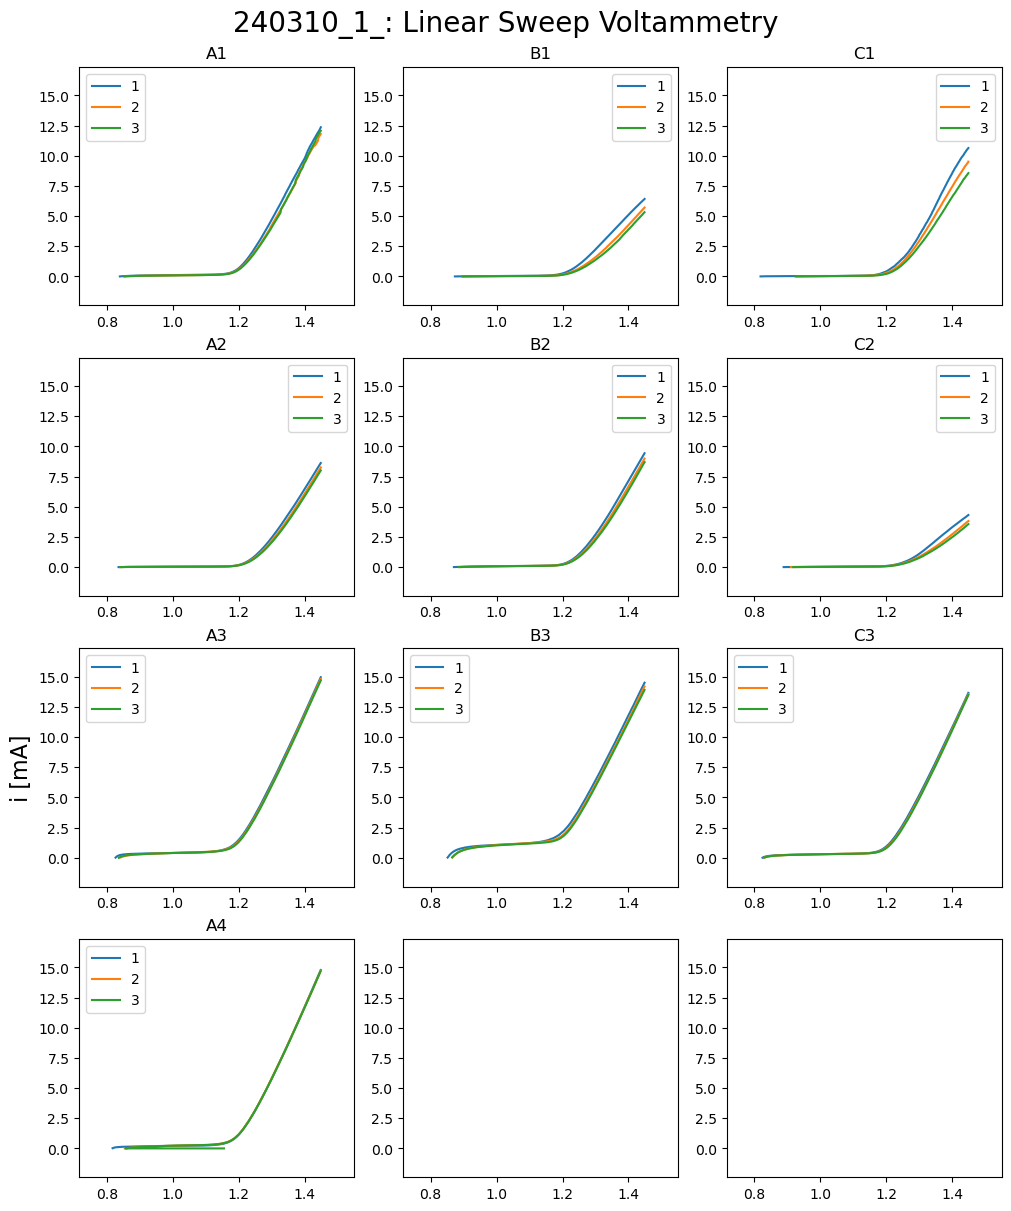

In [58]:
plot_layout(results,colname="LSV", fig_title='Linear Sweep Voltammetry', reps=True)

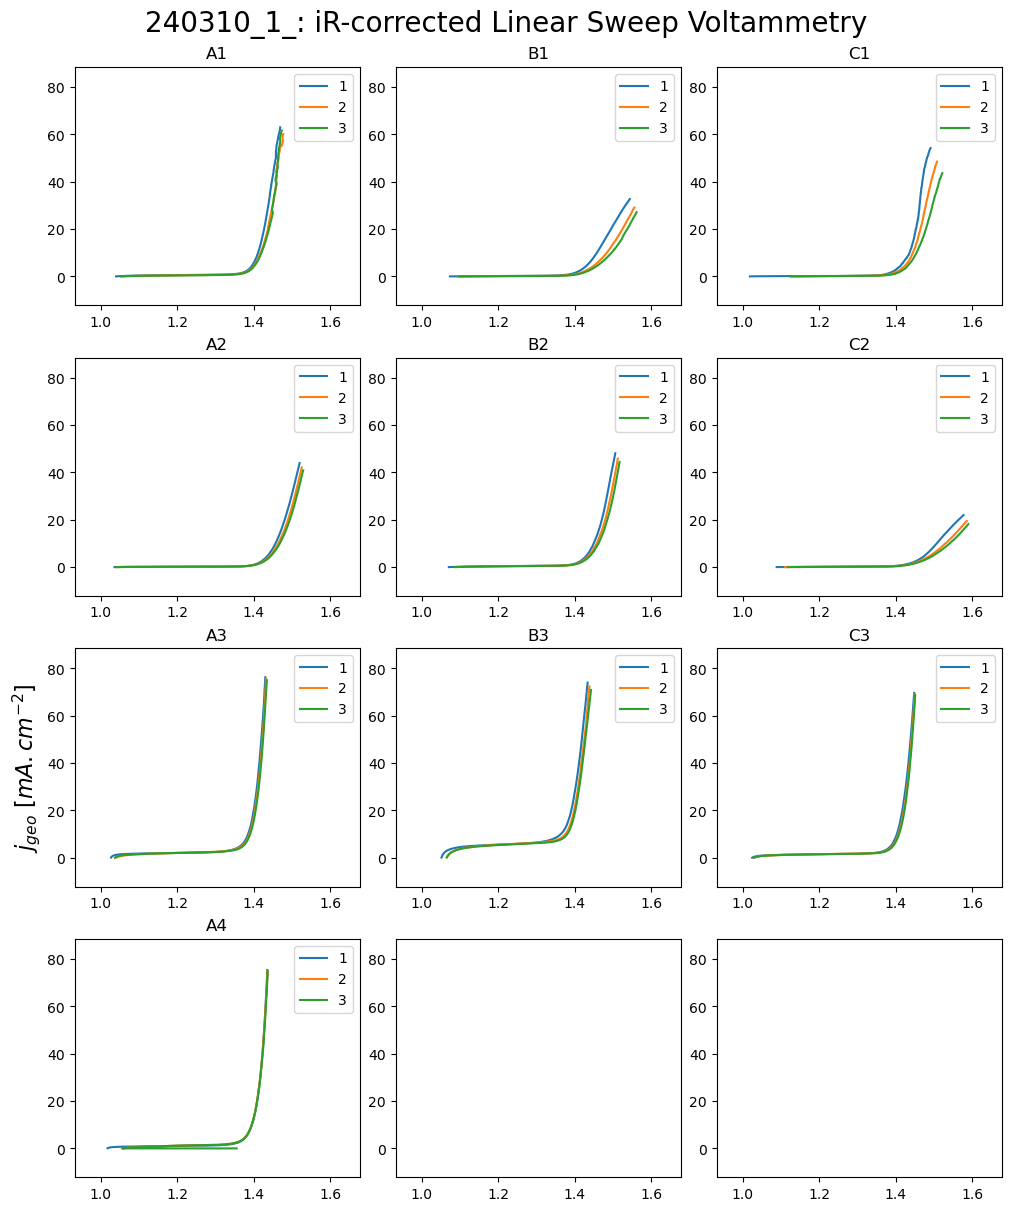

In [59]:
plot_layout(results,colname="LSV_RHE", fig_title='iR-corrected Linear Sweep Voltammetry', reps=True)

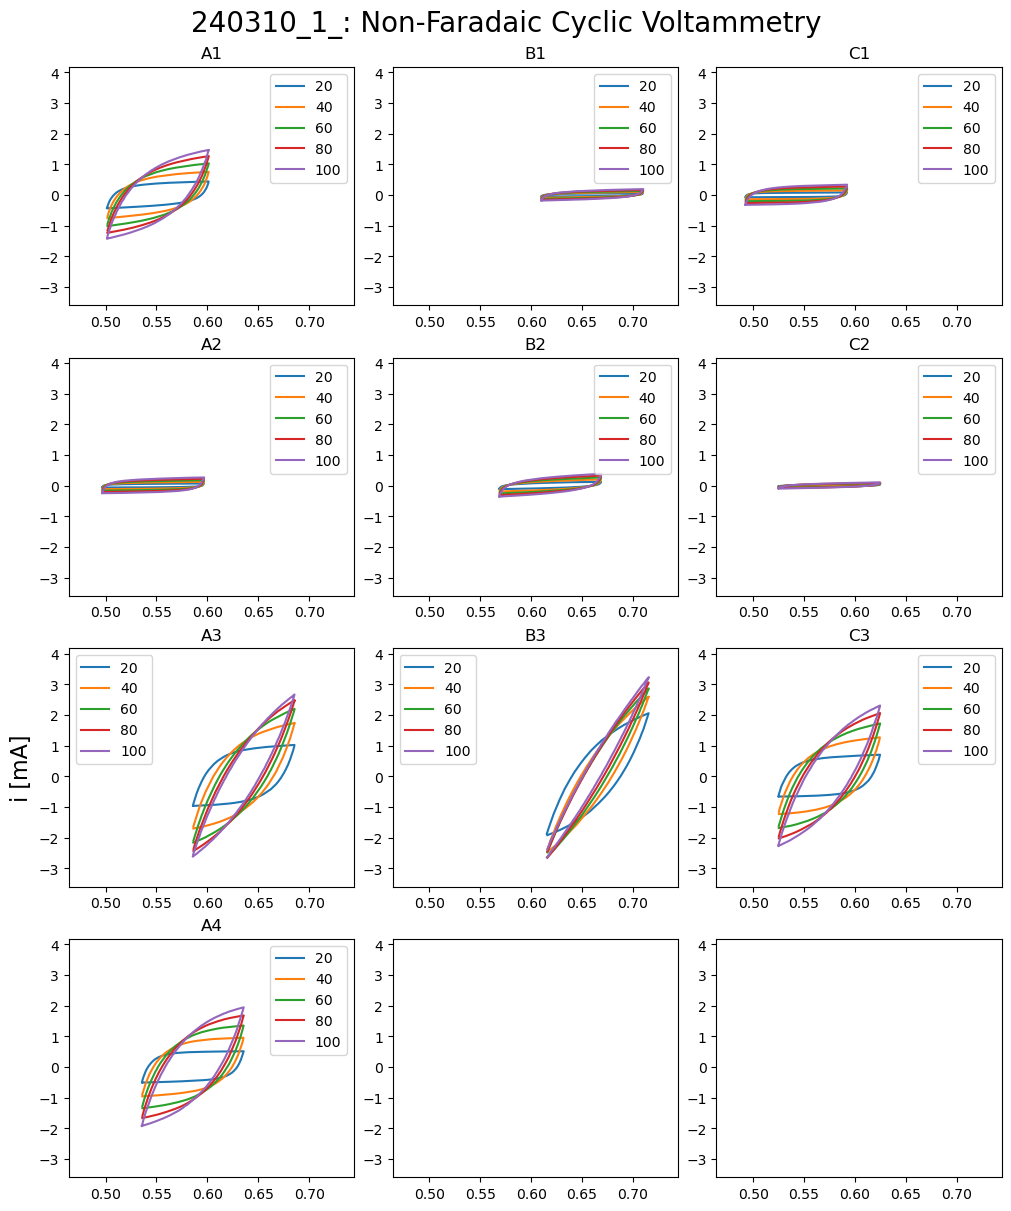

In [60]:
plot_layout(results,colname="CVA", fig_title='Non-Faradaic Cyclic Voltammetry', reps=True)

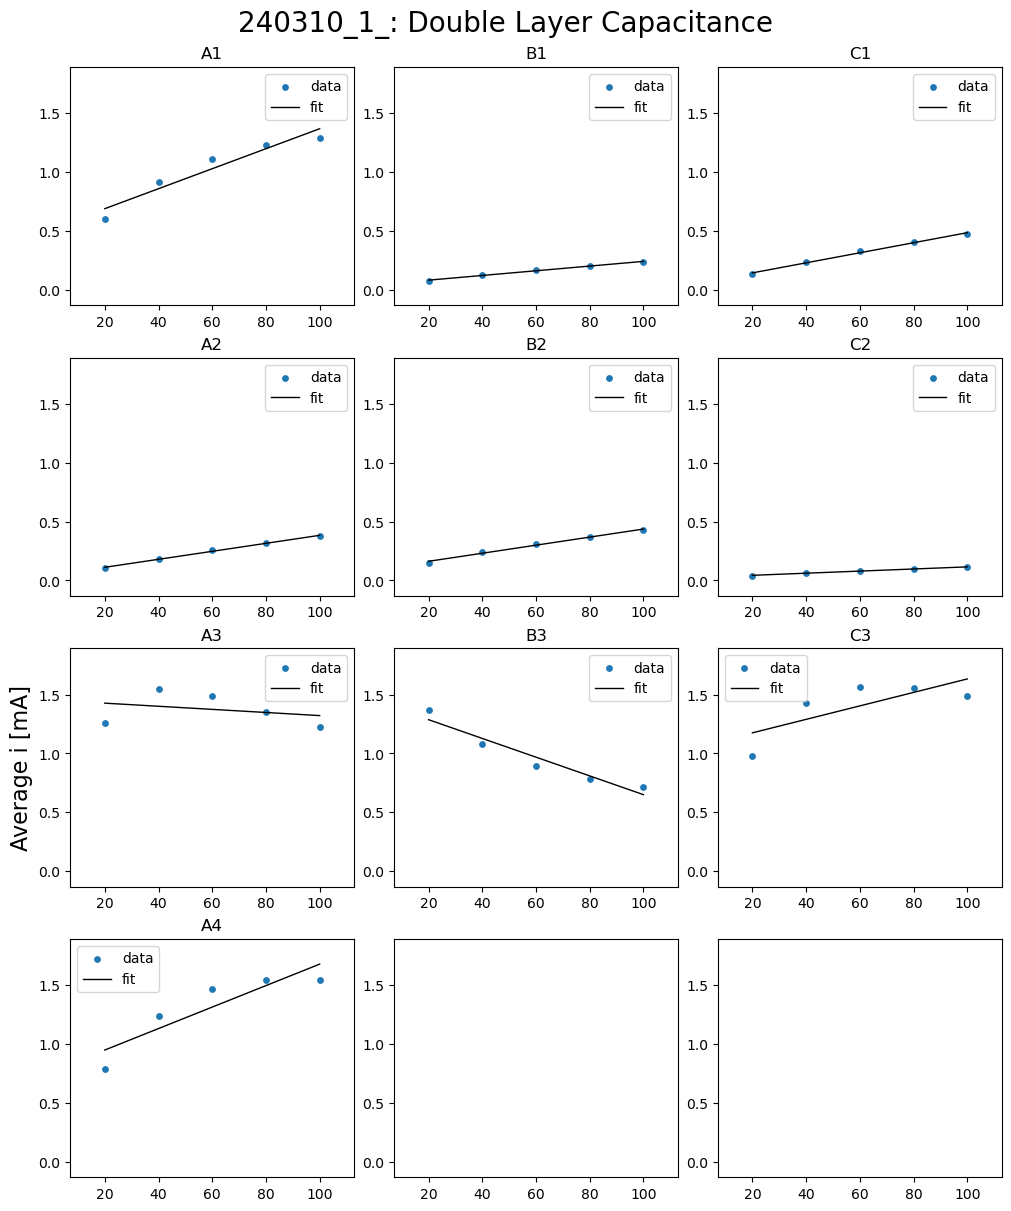

In [61]:
plot_layout(results,colname="Cdl", fig_title='Double Layer Capacitance', plt_type='scatter', fit='Cdl_fit')

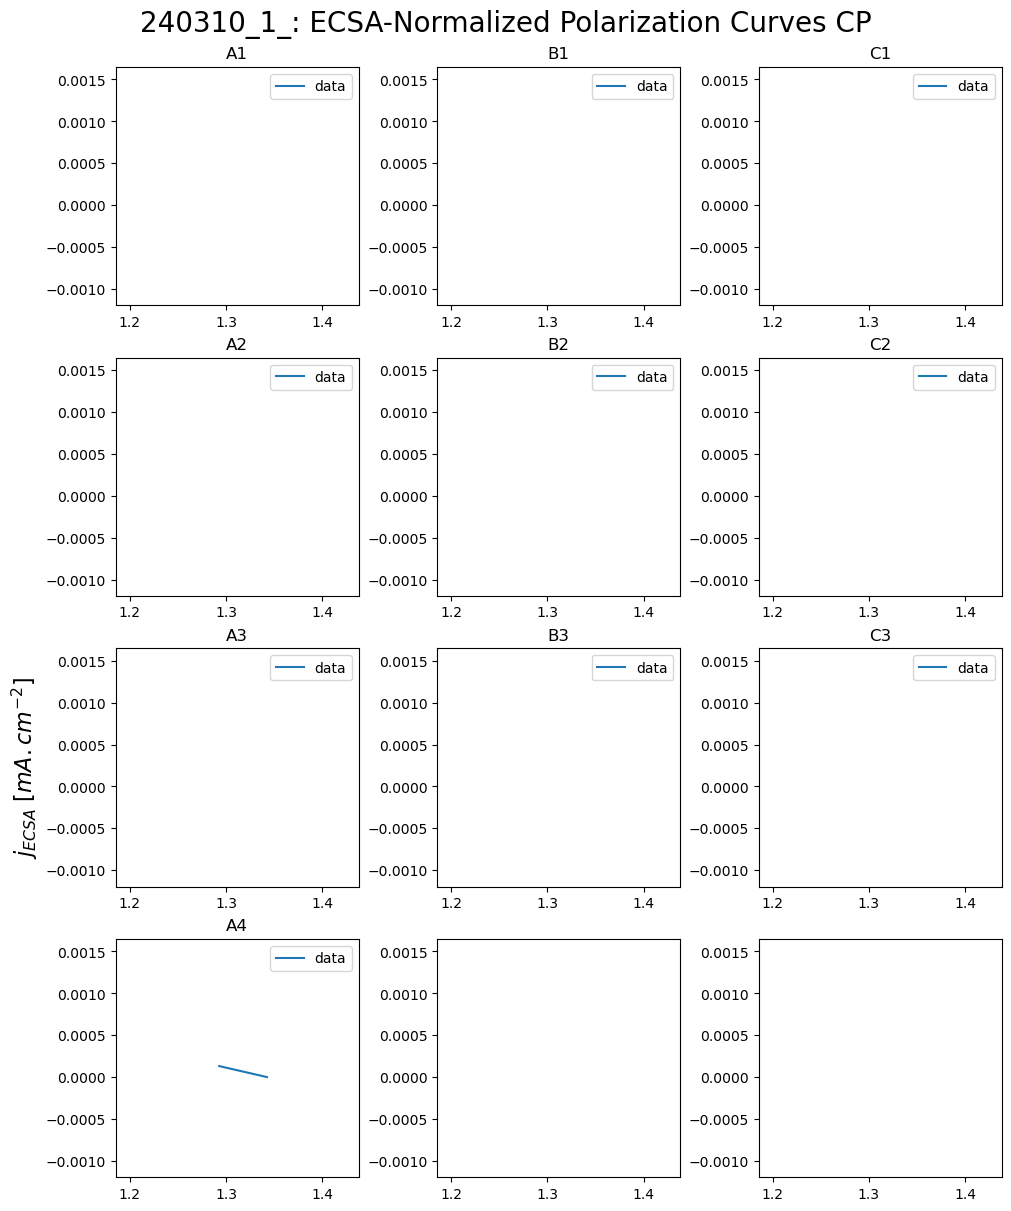

In [62]:
plot_layout(results,colname="pol_cp_ECSA", fig_title='ECSA-Normalized Polarization Curves CP', reps=False, uni_scale=True)

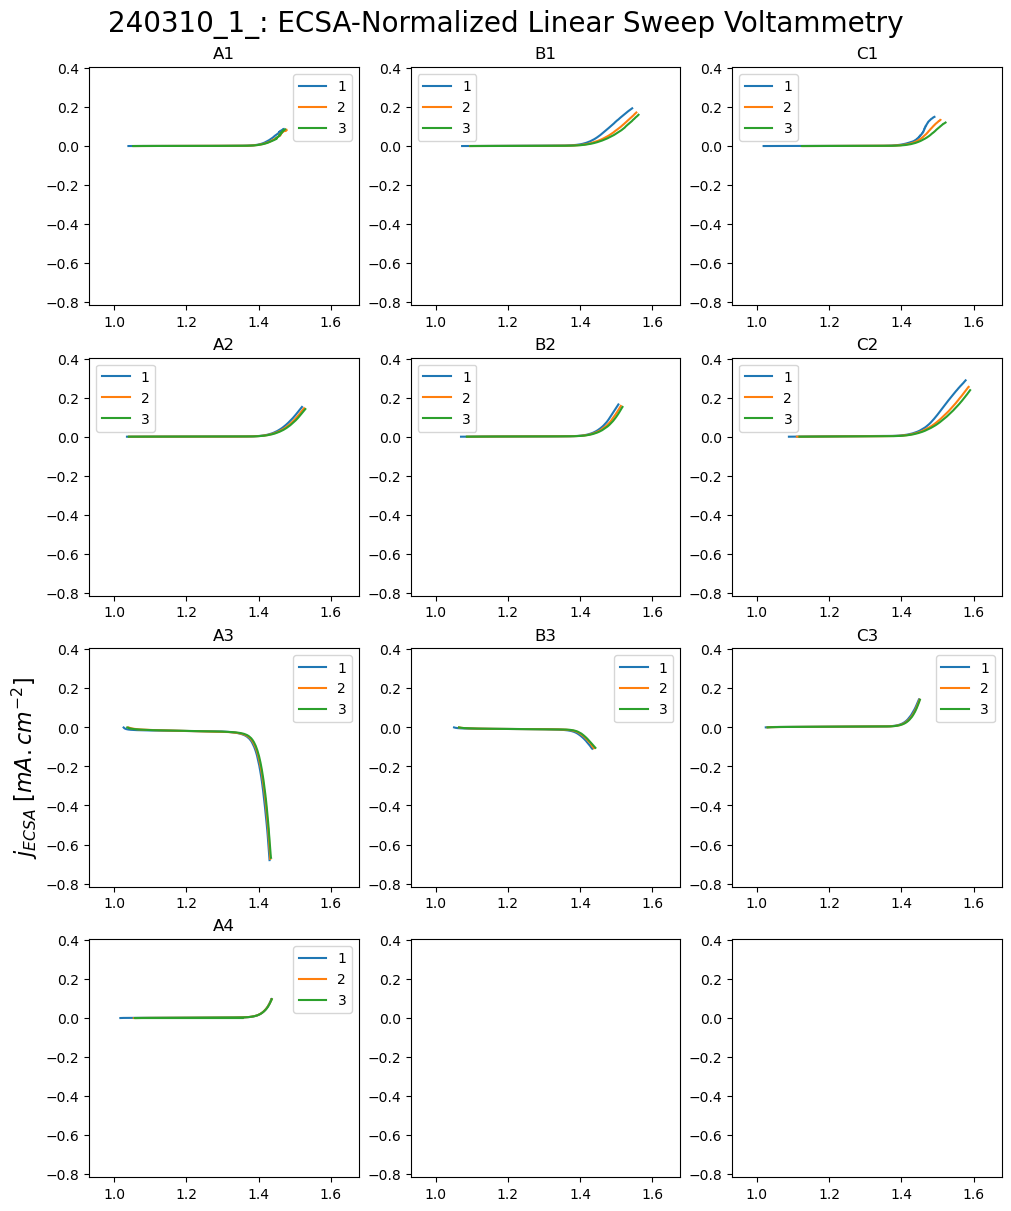

In [63]:
plot_layout(results,colname="LSV_ECSA", fig_title='ECSA-Normalized Linear Sweep Voltammetry', reps=True, uni_scale=True)

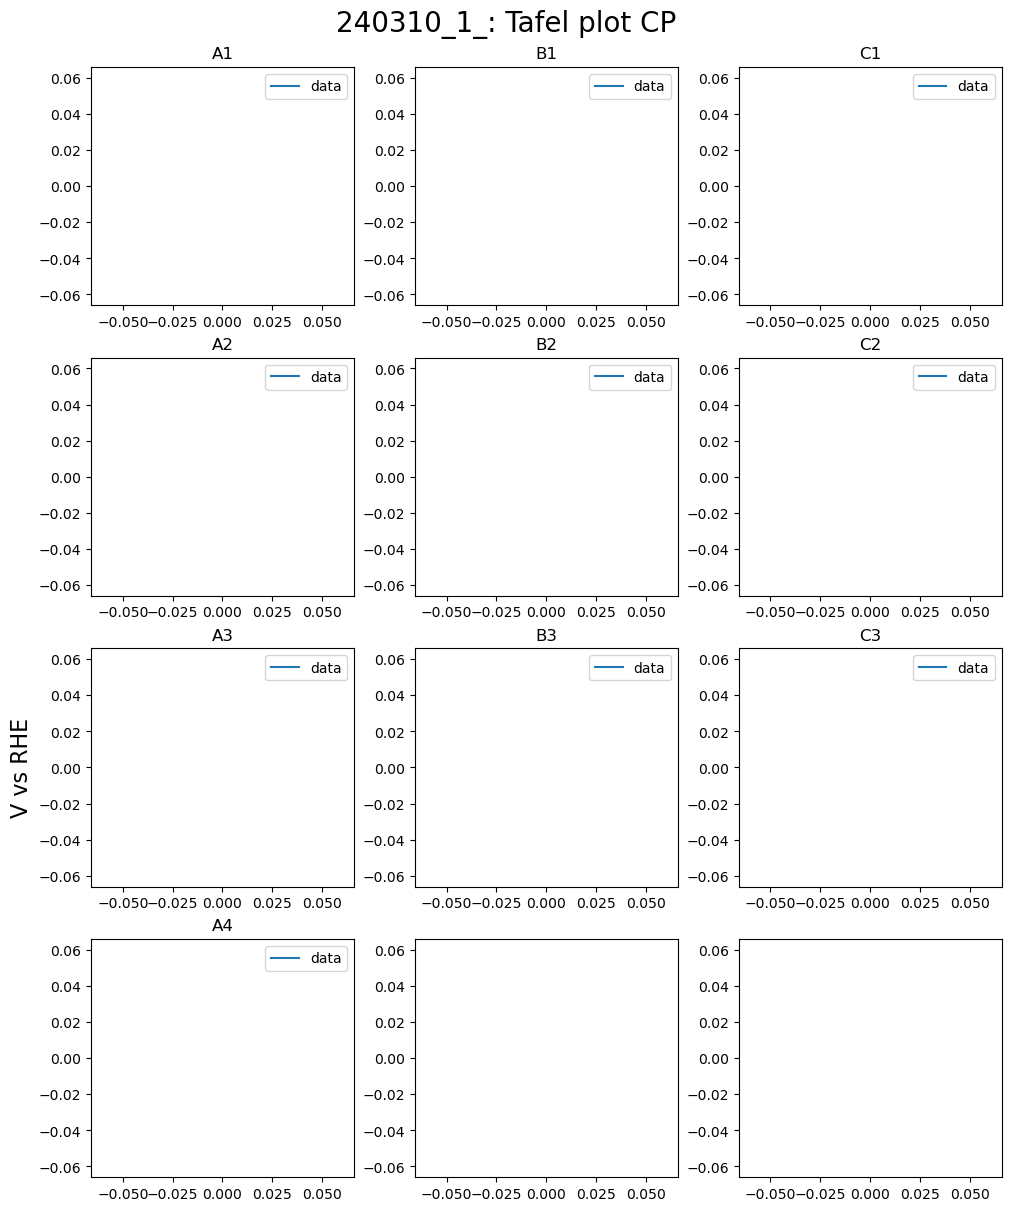

In [64]:
plot_layout(results,colname="pol_cp_Tafel", fig_title='Tafel plot CP', plt_type='line', xrange=[0,1], reps=False, uni_scale=True)

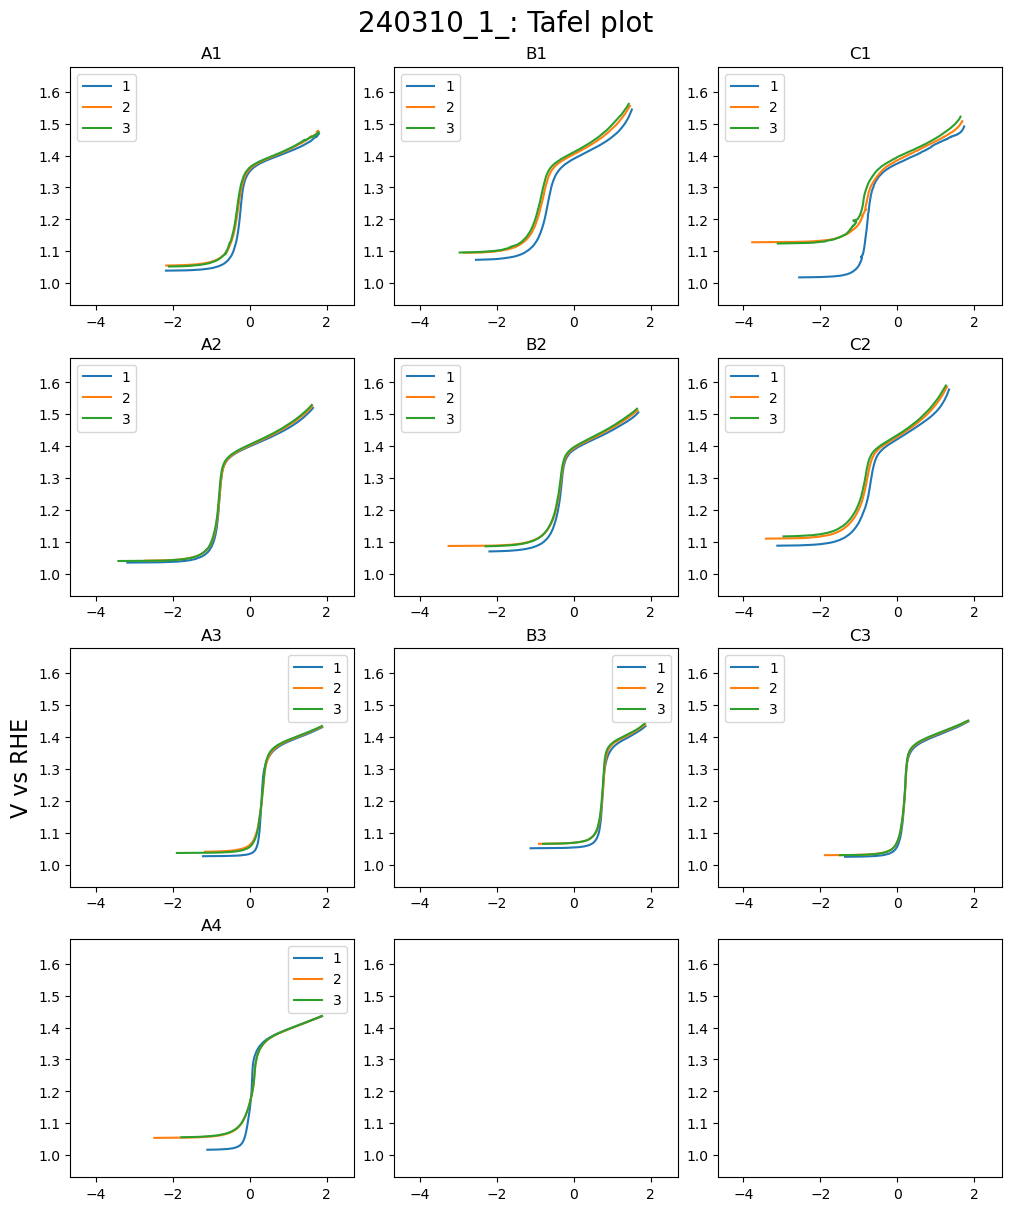

In [65]:
plot_layout(results,colname="LSV_Tafel", fig_title='Tafel plot', plt_type='line', reps=True, uni_scale=True)